# Inverse Probability of Treatment Weights
In the previous tutorial, we used the g-formula (or g-computation algorithm) to estimate the causal effect of ART on the 45-week all cause mortality. That approach required the correct specification of the $\widehat{E}[Y|A,L]$ regression model. That means we had to have all the interaction terms between treatment ($A$) and all confounders ($L$) correctly specified. In this tutorial we will use inverse probability of treatment weights (IPTW). This approach no longer requires us to estimate all the $A$-with-$L$ interaction correctly (in fact, we no longer need to model any of those). We only need to modeling $\widehat{\Pr}(A=a|L)$ instead. 

The unstabilized weights take the following form
$$\widehat{W_i} = \frac{1}{\widehat{\Pr}(A=a|L)}$$
where if an individual was treated ($A=1$), their weight is $\widehat{W_i} = \frac{1}{\widehat{\Pr}(A=1|L)}$ and if untreated ($A=0$), $\widehat{W_i} = \frac{1}{\widehat{\Pr}(A=0|L)}$

To stabilize weights, we modify the numerator. This modification often has little consequence for time-fixed scenarios (infact, unstabilized and stabilized weights should give the same answer) but only stabilized weights are recommended for time-varying weights. Stabilized weights take the following form
$$\widehat{SW_i} = \frac{\widehat{\Pr}(A=a)}{\widehat{\Pr}(A=a|L)}$$

After estimating weights, we then estimate a marginal structural model. The marginal structural model takes the following form
$$\widehat{Y} = \beta_0 + \beta_1 A$$
and the average treatment effect of $A$ on $Y$ is $\beta_1$. 

## Why it works
Before continuing, a brief aside on why this approach works. For the g-formula, we saw how we directly estimated potential outcomes and filled them in. IPTW is not as readily transparent (at least not to me). What this approach does is construct a pseudo-population. In our new pseudo-population the average causal effect of $A$ on $Y$ is the same as the average causal effect in our observed population. However, in our pseudo-population our set of confounders, $L$, are no longer related to $A$. 

Specifically, our probabilities of treatment weight individuals to their treatment. So, if individuals with $L=1$ are less likely to be treated with $A$, those who with $L=1$ and $A=1$ are up-weighted in our pseudo-population. A similar process applies for down-weighting. For further discussion and intuition, I recommend reading through the references listed below

## An example
To motivate our example, we will use a simulated data set included with *zEpid*. In the data set, we have a cohort of HIV-positive individuals. We are interested in the sample average treatment effect of antiretroviral therapy (ART) on all-cause mortality at 45-weeks. Based on substantive background knowledge, we believe that the treated and untreated population are exchangeable based gender, age, CD4 T-cell count, and detectable viral load. 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zepid import load_sample_data, spline

df = load_sample_data(False)
df[['age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=3, term=2, restricted=True)
df[['cd4_rs1', 'cd4_rs2']] = spline(df, 'cd40', n_knots=3, term=2, restricted=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 0 to 546
Data columns (total 13 columns):
id          547 non-null int64
male        547 non-null int64
age0        547 non-null int64
cd40        547 non-null int64
dvl0        547 non-null int64
art         547 non-null int64
dead        517 non-null float64
t           547 non-null float64
cd4_wk45    460 non-null float64
age_rs1     547 non-null float64
age_rs2     547 non-null float64
cd4_rs1     547 non-null float64
cd4_rs2     547 non-null float64
dtypes: float64(7), int64(6)
memory usage: 59.8 KB


With our data loaded, we are now ready to estimate the inverse probability of treatment weights. We can do this by using the `IPTW` class in *zEpid*. This class is initialized with our data set and the column name for the treatment.

### Unstabilized Weights
We will start with estimation with unstabilized weights.

In [2]:
from zepid.causal.ipw import IPTW

iptw = IPTW(df.drop(columns='cd4_wk45'), treatment='art', outcome='dead')

With the specified `IPTW` class, we will now use the `treatment_model()` function. In this model, we will specify $L$. Based on substantive background knowledge, we believe that the treated and untreated population are exchangeable based gender, age, CD4 T-cell count, and detectable viral load. Additionally, we will use spline terms for age and baseline CD4 T-cell count. We will also specify the optional argument `stabilized=False` to obtain unstabilized weights.

In [3]:
iptw.treatment_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     stabilized=False)


----------------------------------------------------------------
MODEL: art ~ male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    art   No. Observations:                  547
Model:                            GLM   Df Residuals:                      538
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -214.63
Date:                Wed, 17 Jul 2019   Deviance:                       429.26
Time:                        12:31:04   Pearson chi2:                     539.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]

After specifying and fitting our regression model, we next need to specify the marginal structural model. The marginal structural model in this example will only include the treatment variable `art`. However, marginal structural models can be specified to assess effect measure modification, as we will see later

the weights can be calculated by calling the `fit()` function. This will calculate the corresponding weights. Afterwards, we can access the `Weights` attribute to return our vector of weights. We will add these to our data set in a new column labeled 'uw' for unstabilized weights

In [4]:
iptw.marginal_structural_model('art')

We are now ready to estimate the parameters for our marginal structural model using the calculated inverse probability of treatment weights. To do this, we call the `fit()` function. 

For the confidence intervals of the marginal structural model, we need to use robust standard errors (sandwich estimator of variance). For some intuition as to why, remember that we are up-weighting some individuals to count for more than one person. However, we are creating exact replicas of them. The replicas are correlated with each other and we need to account for that replication. Confidence intervals can also be calculated using a non-parametric bootstrapping procedure. Confidence intervals from bootstrapping will likely be narrower than the GEE confidence intervals. I wont' demonstrate it, but you can easily adapt other code for bootstrapping and the code below.

In [5]:
iptw.fit()

c:\users\zivic\python programs\development\zepid\zepid\causal\ipw\IPTW.py:353: UserWarning: All missing outcome data is assumed to be missing completely at random. To relax this assumption to outcome data is missing at random please use the `missing_model()` function
  "function", UserWarning)


We see a warning regarding missing data. We can additionally count for missing data using inverse probability of censoring weights. We will return to this concept later.

### Diagnostics
Before going further, let's go through some diagnostics for our weights. All diagnostics can be ran after calling the `fit()` function. Current diagnostics include; distributions of predicted probabilities, Love plots (for confounder balance), and weight distributions

All diagnostics can be run by using `run_diagnostics()` or called individually. 

                     Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
----------------------------------------------------------------------
Mean weight:            1.986
Standard Deviation:     2.366
Minimum weight:         1.06
Maximum weight:         16.919

                Standardized Mean Differences
            smd_w     smd_u
labels                     
male    -0.088567 -0.015684
age0     0.053929  0.022311
age_rs1  0.072832  0.062384
age_rs2  0.071245  0.057444
cd40    -0.022283 -0.486700
cd4_rs1 -0.016827 -0.487005
cd4_rs2 -0.008080 -0.297140
dvl0     0.047828 -0.015729


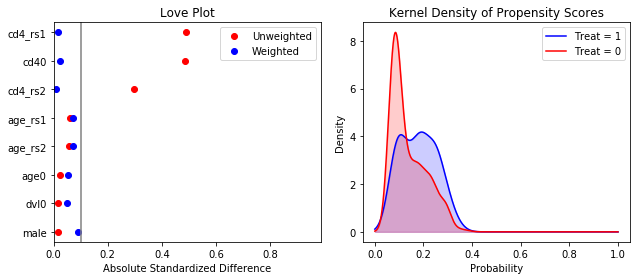

In [6]:
iptw.run_diagnostics()

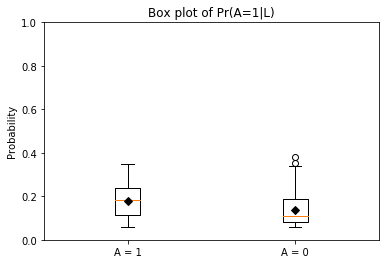

In [7]:
# Box plot of predicted probabilities
iptw.plot_boxplot()
plt.title('Box plot of Pr(A=1|L)')
plt.ylim([0, 1])
plt.show()

Based on these plots, it doesn't look like we have any gross positivity violations. This would suggest our weights aren't doing anything weird and that everyone in the sample has some counterpart who was treated/treated. 

Next, we can look to see how well our covariates are balanced. We can do this by using a Love plot. A Love plot displays the absolute values of the standardized mean differences for all covariates. It will present the standardized mean differences for the unweighted and weighted data. Based on the above Love plot, we have pretty good balance of our confounders in the weighted population. As a general rule of thumb, all covariates should be below a standardized mean difference of 0.10. So, this suggests we are accounting for the measured confounders adequately. If there was still imbalance, we might consider adding interaction terms or different splines for continuous covariates.

Lastly, we will assess the behavior of the weights. From this, we get some summary statistics for our weights. As the above documentation suggests, the average weight for unstabilized weights should be 2. Our mean weight is 1.986, which is fairly close. Additionally, the maximum and minimum weights are not too crazy (if maximum weight was 100+, there might be some concerns regarding positivity). To correct for these issues, we could return to the `treatment_model()` and specify the optional argument `bound`, which allows truncating weights based on predicted probabilities.

### Estimates
To view the estimates, we can use the `summary()` function

In [8]:
iptw.summary()

              Inverse Probability of Treatment Weights                
Treatment:        art             No. Observations:     547                 
Outcome:          dead            No. Missing Outcome:  30                  
g-Model:          Logistic        Missing Model:        None                
Risk Difference
----------------------------------------------------------------------
              RD  SE(RD)  95%LCL  95%UCL
labels                                  
Intercept  0.182   0.019   0.145   0.218
art       -0.082   0.038  -0.156  -0.007
----------------------------------------------------------------------
Risk Ratio
              RR  SE(log(RR))  95%LCL  95%UCL
labels                                       
Intercept  0.182        0.103   0.148   0.222
art        0.551        0.347   0.279   1.088
----------------------------------------------------------------------
Odds Ratio
              OR  SE(log(OR))  95%LCL  95%UCL
labels                                       
Interce

From these results we would conclude that the 45-week risk of death when everyone was treated with ART was 8.2% points lower (95% CL: -0.15.6, -0.7) than if no one had been treatd with ART.

These results are fairly close to the `TimeFixedGFormula` results. The results are not the same because we have model misspecification for (at least one of) our parametric regression models. If you are worried about model misspecification (you should be), I would recommend fitting both. If the results are fairly similar, you can rest easy. If they are different (and even if they are not), then I would recommend using a doubly robust estimator (like `AIPTW`).

## Stabilized Weights
Below is code to generate the stabilized weights. The `IPTW` class defaults to stabilized weights. The process is largely the same. I will also run `positivity()` to show the difference in the weight distribution

In [9]:
# Calculating stabilized weights
iptw = IPTW(df.drop(columns='cd4_wk45'), treatment='art', outcome='dead')
iptw.treatment_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     print_results=False)
iptw.marginal_structural_model('art')
iptw.fit()

# Positivity diagnostic
iptw.positivity()

c:\users\zivic\python programs\development\zepid\zepid\causal\ipw\IPTW.py:353: UserWarning: All missing outcome data is assumed to be missing completely at random. To relax this assumption to outcome data is missing at random please use the `missing_model()` function
  "function", UserWarning)


                     Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
----------------------------------------------------------------------
Mean weight:            0.998
Standard Deviation:     0.203
Minimum weight:         0.416
Maximum weight:         2.444


In [10]:
iptw.summary()

              Inverse Probability of Treatment Weights                
Treatment:        art             No. Observations:     547                 
Outcome:          dead            No. Missing Outcome:  30                  
g-Model:          Logistic        Missing Model:        None                
Risk Difference
----------------------------------------------------------------------
              RD  SE(RD)  95%LCL  95%UCL
labels                                  
Intercept  0.182   0.019   0.145   0.218
art       -0.082   0.038  -0.156  -0.007
----------------------------------------------------------------------
Risk Ratio
              RR  SE(log(RR))  95%LCL  95%UCL
labels                                       
Intercept  0.182        0.103   0.148   0.222
art        0.551        0.347   0.279   1.088
----------------------------------------------------------------------
Odds Ratio
              OR  SE(log(OR))  95%LCL  95%UCL
labels                                       
Interce

The stabilized weights give the same answer, as expected. As long as the marginal structural model is saturated, stabilized and unstabilized weights should provide the same answer.

## Continuous Outcomes
Estimating the average treatment effect for continuous outcomes is easy. Since we are modeling the treatment, a continuous outcome doesn't not change how we would calculate weights. Additionally, `IPTW` auto-detects continuous data. Either a Normal or Poisson model can be used for continuous outcomes for the marginal structural model. To motivate this example, we will assess the causal effect of ART on CD4 T-cell count at 45 weeks (we will ignore the implications of competing risk for now)

Let's go through the example with stabilized weights

In [11]:
iptw = IPTW(df.drop(columns='dead'), treatment='art', outcome='cd4_wk45')
iptw.treatment_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     print_results=False)
iptw.marginal_structural_model('art')
iptw.fit()
iptw.summary()

              Inverse Probability of Treatment Weights                
Treatment:        art             No. Observations:     547                 
Outcome:          cd4_wk45        No. Missing Outcome:  87                  
g-Model:          Logistic        Missing Model:        None                
Average Treatment Effect
----------------------------------------------------------------------
                ATE  SE(ATE)    95%LCL    95%UCL
labels                                          
Intercept  1072.318   22.687  1027.852  1116.784
art         209.904   55.469   101.187   318.620


c:\users\zivic\python programs\development\zepid\zepid\causal\ipw\IPTW.py:353: UserWarning: All missing outcome data is assumed to be missing completely at random. To relax this assumption to outcome data is missing at random please use the `missing_model()` function
  "function", UserWarning)


Therefore, under the counterfactual where everyone had been treated with ART, the mean CD4 T-cell count of study participants would be 209.9 (95% CL: 101.2, 318.8) higher compared to the counterfactual where no one was treated. However, we have been making a strong assumption throughout (that is easy to miss, but less so because of the `IPTW` warning). Do you know what it is?

## Missing Data
Both `dead` (n=517) and `cd4_wk45` (n=460) have missing data. These may be referred to as censoring (censoring is a special case of missing data, where data is missing on the outcome). Missing data is now easy to account for using `IPTW` with the `missing_model()` function. This function allows specification of a model to account for missing outcome data. In the `fit()` function, both the treatment weights and censoring weights are multiplied to obtain the full inverse probability weights. These full weights are then used to fit the marginal structural model.

We will assume outcome data is missing completely at random conditional on our confounders and ART. We will demonstrate for both `dead` and `cd4_wk45`.

In [12]:
# Estimating ATE for `dead` with IPTW and IPCW
iptw = IPTW(df.drop(columns='cd4_wk45'), treatment='art', outcome='dead')
iptw.treatment_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     print_results=False)
iptw.missing_model('art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     print_results=False)
iptw.marginal_structural_model('art')
iptw.fit()
iptw.summary()

              Inverse Probability of Treatment Weights                
Treatment:        art             No. Observations:     547                 
Outcome:          dead            No. Missing Outcome:  30                  
g-Model:          Logistic        Missing Model:        Logistic            
Risk Difference
----------------------------------------------------------------------
              RD  SE(RD)  95%LCL  95%UCL
labels                                  
Intercept  0.182   0.019   0.145   0.219
art       -0.081   0.039  -0.156  -0.005
----------------------------------------------------------------------
Risk Ratio
              RR  SE(log(RR))  95%LCL  95%UCL
labels                                       
Intercept  0.182        0.103   0.149   0.223
art        0.556        0.347   0.282   1.098
----------------------------------------------------------------------
Odds Ratio
              OR  SE(log(OR))  95%LCL  95%UCL
labels                                       
Interce

In [13]:
# Estimating ATE for `cd4_wk45` with IPTW and IPCW
iptw = IPTW(df.drop(columns='dead'), treatment='art', outcome='cd4_wk45')
iptw.treatment_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     print_results=False)
iptw.missing_model('art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     print_results=False)
iptw.marginal_structural_model('art')
iptw.fit()
iptw.summary()

              Inverse Probability of Treatment Weights                
Treatment:        art             No. Observations:     547                 
Outcome:          cd4_wk45        No. Missing Outcome:  87                  
g-Model:          Logistic        Missing Model:        Logistic            
Average Treatment Effect
----------------------------------------------------------------------
                ATE  SE(ATE)    95%LCL    95%UCL
labels                                          
Intercept  1071.118   23.067  1025.908  1116.328
art         205.112   55.219    96.885   313.339


Our results are fairly similar when adding IPCW. This approach has the advantage of making less restrictive assumptions than the previous model.

## Effect Measure Modification
Finally, we can assess effect measure modification by specifying alternative marginal structural models. In our example, we will focus on modification by gender. The major difference from previous code is that we expand our marginal structural model. Our marginal structural model is now 
$$E[Y^a|V] = \beta_0 + \beta_1 a + \beta_2 V a + \beta_3 V$$
where $V$ is our modifier (male)

We can conclude that there is effect modification if $\beta_2$ in not null. Note that this is no longer a *marginal* structural model, since we are actually conditioning on $V$ in the model. However, we still use the term MSM. For creating the weights, the set $L$ must contain $V$. We will construct the stabilized weights with the following formula. Note that I will write $V$ separate from $L$ to emphasize it is part of both the numerator and denominator
$$\hat{w}_i = \frac{\widehat{\Pr}(A_i=a|V_i)}{\widehat{\Pr}(A=a|V_i, L_i)}$$
For estimation of these new weights in *zEpid*, we will add another optional argument. This argument is part of the regression model statement. We will specify `model_numerator='male'`, which tells *zEpid* that we want the conditional probability in the numerator.

In [14]:
# Estimating ATE for `dead` with IPTW and IPCW
iptw = IPTW(df.drop(columns='cd4_wk45'), treatment='art', outcome='dead')
iptw.treatment_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                     model_numerator='male',
                     print_results=False)
iptw.missing_model('art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                   model_numerator='art + male + art:male',
                   print_results=False)
iptw.marginal_structural_model('art + male + art:male')
iptw.fit()
iptw.summary()

              Inverse Probability of Treatment Weights                
Treatment:        art             No. Observations:     547                 
Outcome:          dead            No. Missing Outcome:  30                  
g-Model:          Logistic        Missing Model:        Logistic            
Risk Difference
----------------------------------------------------------------------
              RD  SE(RD)  95%LCL  95%UCL
labels                                  
Intercept  0.208   0.046   0.118   0.299
art       -0.113   0.101  -0.311   0.085
male      -0.032   0.051  -0.131   0.067
art:male   0.040   0.109  -0.173   0.253
----------------------------------------------------------------------
Risk Ratio
              RR  SE(log(RR))  95%LCL  95%UCL
labels                                       
Intercept  0.208        0.222   0.135   0.322
art        0.457        0.968   0.069   3.046
male       0.847        0.251   0.518   1.385
art:male   1.281        1.031   0.170   9.651
-------

 Based on these results, we don't have strong evidence for effect measure modfication on either the additive or the multiplicative scale. The reason we likely don't see modification on either scale is due to small cells. 

# Conclusions
In this tutorial, I have went through the basics of inverse probability of treatment weights and using them to estimate marginal structural models. I demonstrated how to estimate a marginal structural model using *zEpid* to estimate causal effects of treatment. Next, I demonstrated how to make less restrictive assumptions regarding missing data with inverse probability of censoring weights. Lastly, I demonstrated how to assess effect measure modification using IPTW. In the next tutorial, we will go through a version of IPTW to estimate the average treatment effect in the (un)treated.

## References
Robins JM, Hernan MA, Brumback B. (2000). Marginal structural models and causal inference in epidemiology.

Hernán MÁ, Brumback B, Robins JM. (2000). Marginal structural models to estimate the causal effect of zidovudine on the survival of HIV-positive men. Epidemiology, 561-570.

Cole SR, Hernán MA. (2008). Constructing inverse probability weights for marginal structural models. American journal of epidemiology, 168(6), 656-664.

Austin PC, Stuart EA. (2015). Moving towards best practice when using inverse probability of treatment weighting (IPTW) using the propensity score to estimate causal treatment effects in observational studies. Statistics in medicine, 34(28), 3661-3679.

Love T. (2004). Graphical Display of Covariate Balance. Presentation, See http://chrp.org/love/JSM2004RoundTableHandout. pdf, 1364.